In [224]:
using Base: @kwdef
using Parameters: @unpack
using Plots
using LinearAlgebra
using Distributions, Random

#### 一層目には10個のポワソンスパイクニューロン、二層目には1個のLIFニューロンがある想定でランダムネットワークが構築されている。

In [225]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)

@kwdef struct DESParameter{FT}
    td::FT = 1e-2
    tr::FT = 1e-2
end

@kwdef mutable struct DES{FT}
    param::DESParameter = DESParameter{FT}()
    N::UInt32 # ニューロンの数
    r_double::Vector{FT} = zeros(N)
    hr::Vector{FT} = zeros(N)
end 

#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function DESupdate!(variable::DES, param::DESParameter, r_double, hr, spike, dt)
    @unpack N = variable
    @unpack td, tr = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        r_double[i] = r_double[i]*(1-dt/tr) + hr[i]*dt
        hr[i] = hr[i]*(1-dt/td) + spike/(tr*td)
    end
end

DESupdate! (generic function with 3 methods)

In [226]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)

@kwdef struct CurrentLIFParameter{FT}
    tref::FT = 5e-3 #不応期(ms)
    tc_m::FT = 1e-2 # 膜時定数(ms)
    vrest::FT = -65 # 静止膜電位(mV)
    vreset::FT = -60 # リセット電位(mV)
    vthr::FT = -40 # 閾膜電位(mV)
    vpeak::FT = 30 # ピーク電位(mV)
end

@kwdef mutable struct CurrentLIF{FT}
    param::CurrentLIFParameter = CurrentLIFParameter{FT}()
    N::UInt32 # ニューロンの数
    v::Vector{FT} = fill(-65.0, N) # 膜電位(mV)
    v_::Vector{FT} = fill(-65.0, N) # 発火電位も記録する変数
    fire::Vector{Bool} = zeros(Bool, N) # 発火
    tlast::Vector{FT} = zeros(N) # 最後の発火時刻(ms)
    tcount::FT = 0 # 時間カウント
end 

#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function cupdate!(variable::CurrentLIF, param::CurrentLIFParameter, I::Vector, dt)
    @unpack N, v, v_, fire, tlast, tcount = variable
    @unpack tref, tc_m, vrest, vreset, vthr, vpeak = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        v[i] += dt * ((dt*tcount) > (tlast[i] + tref)) * ((vrest - v[i] + I[i]) / tc_m)
    end
    @inbounds @simd for i = i:N
        fire[i] = v[i] >= vthr
        v_[i] = ifelse(fire[i], vpeak, v[i])
        v[i] = ifelse(fire[i], vreset, v[i])
        tlast[i] = ifelse(fire[i], dt*tcount, tlast[i]) # 発火時刻の更新
    end
end

cupdate! (generic function with 1 method)

In [227]:
dt, T = 1e-4, 1 # タイムステップ, シミュレーション時間 (sec)
nt = Int(T/dt) # シミュレーションの総ステップ
num_in = 10
num_out = 1

# 入力のポワソンスパイク
fr_in = 30
#spikes = rand(nt, num_in) .< fr_in*dt
spikes = ifelse.(rand(nt, num_in) .< fr_in*dt, 1, 0)
### 普通にランダムにWを生成してみたい時
W = 0.2*rand(num_out,num_in)
### 特定の正規分布などで重み行列を生成してみたいとき
#d = Normal(1.0, 0.5)
# 打ち切りしたい時
#td = truncated(d, 0.0, Inf)
#W = 0.1*rand(d,num_out,num_in)'

# modelの定義
neurons = CurrentLIF{Float64}(N=num_out)
synapses = DES{Float64}(N=num_out)

# 記録用
current = zeros(Float64, num_out, nt)
voltage = zeros(Float64, num_out, nt)

r_double = zeros(Float64, num_out)
hr = zeros(Float64, num_out)

@time for t in 1:nt
    
    DESupdate!(synapses, synapses.param, r_double, hr, dot(W,spikes[t,:]), dt)
    current[:,t] = synapses.r_double 
    
    cupdate!(neurons, neurons.param, synapses.r_double, dt)
    neurons.tcount += 1
    voltage[:,t] = neurons.v_  
    
    # ここの更新だけ必要になってくるので注意する必要性がある。　
    r_double = synapses.r_double 
    hr = synapses.hr
    
end 

  0.049280 seconds (372.51 k allocations: 12.400 MiB)


In [228]:
using LinearAlgebra
100*dot(W,spikes[2,:])

0.0

In [229]:
current

1×10000 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  20.8892  21.0322  21.1703  21.3036

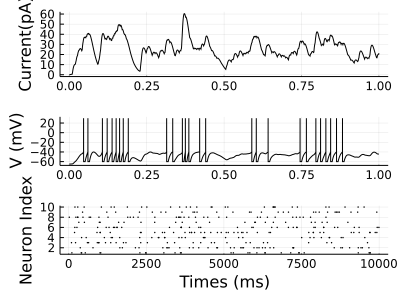

In [230]:
t = Array{Float32}(1:nt)*dt
p1 = plot(t, current[1, :], color="black")
p2 = plot(t, voltage[1, :], color="black")

spike_inds = Tuple.(findall(x -> x > 0, spikes)) # 行列内で0を超えてるスパイクのインデックスの要素を取得
spike_time = first.(spike_inds) # スパイク時系列
neuron_inds = last.(spike_inds) # 神経の番号(1~n_neurons)
p3 = plot(spike_time, neuron_inds ,st=:scatter,markersize=1,color="black")


plot(p1, p2, p3,
    xlabel = ["" "" "Times (ms)"], 
    ylabel= ["Current(pA)"　"V (mV)" "Neuron Index"],
    layout = grid(3, 1, heights=[0.4, 0.3, 0.3]), legend=false, size=(400,300))

In [231]:
using Distributions, Random

d = Normal(1.0, 0.5)

# 打ち切りしたい時
#td = truncated(d, 0.0, Inf)

rand(d, 20,10)'

10×20 Adjoint{Float64,Array{Float64,2}}:
 1.52952   0.962853   1.20334    0.762726  …  0.510669   0.496015   0.962518
 0.976754  0.322668   1.5747     0.322677     0.605149   0.842565   1.05752
 0.949257  0.894219   1.2893     1.18751      1.06962    1.12445    1.10534
 0.814778  1.22153    1.12062    1.23283      1.62052    0.500872   0.190313
 0.281029  0.459565  -0.0285118  1.19078      1.09351    1.51914    0.564355
 1.10989   0.609429   1.29542    0.979797  …  1.20129   -0.74912    0.865676
 0.457001  1.7111     1.55238    1.23669      1.6661     1.23774    1.50952
 0.639381  0.767776   0.642953   1.98458      0.833934   0.878763   1.31338
 1.99712   0.589372   0.82858    0.641404     1.10436    2.40624    1.04956
 0.818468  0.734024   1.35208    1.56781      1.16477   -0.0681479  1.00394